In [1]:
import pandas as pd 
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from datetime import datetime, timedelta, time
from keras.layers import Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [3]:
def build_model(num_units, n_steps, n_features):
  model = Sequential()
  model.add(Bidirectional(LSTM(num_units, activation='relu'), input_shape=(n_steps, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [4]:
def get_model_input(df, n_steps = 8,n_features = 1):
  try:
    raw_seq = df
    X, y = split_sequence(raw_seq, n_steps) 
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return raw_seq,X,y
  except:
    print("Exception for ", X)

In [5]:
df_path = "/content/drive/MyDrive/LSTM_POWER_CLUSTERING/data/fl_data/partial_full.csv"
def read_df(my_path):
  df = pd.read_csv(my_path,infer_datetime_format=True)
  df["dt"] = pd.to_datetime(df["dt"])
  df = df.set_index("dt")
  df = df.sort_index()
  return df

In [6]:
df = read_df(df_path)
df = df.sort_index()
values = df["demand"].values.tolist()[0:]
#train = values[:18000]
#test = values[18000:]
train = df.iloc[:18000]
test = df.iloc[18000:]
new_path = "/content/drive/MyDrive/LSTM_POWER_CLUSTERING/data/fl_data/pre_processed_mi_tail.csv"
new_df = read_df(new_path)
validation = new_df.iloc[:]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [8]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
scaled_validation = scaler.transform(validation)

In [9]:
scaled_train = scaled_train.reshape(scaled_train.shape[0],).tolist()
scaled_test = scaled_test.reshape(scaled_test.shape[0],).tolist()
scaled_validation = scaled_validation.reshape(scaled_validation.shape[0],).tolist()

In [10]:
def prepare_model(values, n_steps = 8, n_features = 1, n_units = 50, num_epochs=200):
  raw_seq, X, y = get_model_input(values, n_steps, n_features)
  model = build_model(n_units, n_steps, n_features)
  history = model.fit(X, y, epochs=num_epochs, verbose=0)
  return model, history

In [11]:
def predict_model(values, model,n_steps=8):
  output = pd.DataFrame()
  for i in range(len(values) - n_steps - 1):
    lst = values[i:i+n_steps]
    y = values[i+n_steps]
    x_inputs = np.array(lst)
    x_input_reshaped = x_inputs.reshape((1, n_steps, 1))
    yhat = model.predict(x_input_reshaped, verbose=0)
    if y > 0:
      output = output.append({"Actual Demand": y, "Predicted Demand": yhat[0][0]}, ignore_index=True)
  return output

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [13]:
def evl(train, model, n_steps):
  output = predict_model(train, model, n_steps)
  rmse=sqrt(mean_squared_error(output['Actual Demand'],output['Predicted Demand']))
  return rmse, output

In [14]:
lags = [6,8,12]
units = [50, 60, 70, 80, 90, 100, 110, 120]
hyper_param_list = []
for i in lags:
  for j in units:
    hyper_param_list.append([i,j])

In [15]:
my_items = []
selected_model = None
selected_history = None
selected_output = None
min_rmse = 1000000
min_lag = 100000
min_units = 10000

sx_min_rmse = 100000
et_min_rmse = 100000
tw_min_rmse = 100000

sx_min_units = 100000
et_min_units = 100000
tw_min_units = 100000

for item in hyper_param_list:
  model, history = prepare_model(scaled_train, n_steps=item[0], n_features=1, n_units=item[1], num_epochs = 100)
  rmse, output = evl(scaled_test,model, n_steps=item[0])
  output = scaler.inverse_transform(output)

  if item[0] == 6 and sx_min_rmse > rmse:
    sx_min_rmse = rmse
    sx_min_units = item[1]
  elif item[0] == 8 and et_min_rmse > rmse:
    et_min_rmse = rmse
    et_min_units = item[1]
  elif item[0] == 12 and tw_min_rmse > rmse:
    tw_min_rmse = rmse
    tw_min_units = item[1]

  if rmse < min_rmse:
    min_rmse = rmse
    min_unit = item[1]
    min_lag = item[0]
    selected_model = model
    selected_history = history
    selected_output = output
  item.append(rmse)
  my_items.append(item)
  print(item)

[6, 50, 0.028147368236953255]
[6, 60, 0.027258898415989347]
[6, 70, 0.02917238538252102]
[6, 80, 0.030443299843284966]
[6, 90, 0.03088909333214786]
[6, 100, 0.02852057816500381]
[6, 110, 0.028178732724760396]
[6, 120, 0.02786565011178762]
[8, 50, 0.026269634307431042]
[8, 60, 0.028342305170593846]
[8, 70, 0.02595529694478254]
[8, 80, 0.021820544018648302]
[8, 90, 0.02464716576411856]
[8, 100, 0.028242030259414668]
[8, 110, 0.03042831707816873]
[8, 120, 0.026415113744023003]
[12, 50, 0.021003064779871246]
[12, 60, 0.032398699667395274]
[12, 70, 0.0215224937973779]
[12, 80, 0.025857547815597383]
[12, 90, 0.02255557920528789]
[12, 100, 0.019561714187339527]
[12, 110, 0.019351388122203012]
[12, 120, 0.01967048580524447]


In [16]:
six_step_list = {}
eight_step_list = {}
twelve_step_list = {}
for item in my_items:
  if item[0] == 6:
    six_step_list[item[1]] = item[2]
  elif item[0] == 8:
    eight_step_list[item[1]] = item[2]
  else:
    twelve_step_list[item[1]] = item[2]

[Text(0, 0.5, 'RMSE')]

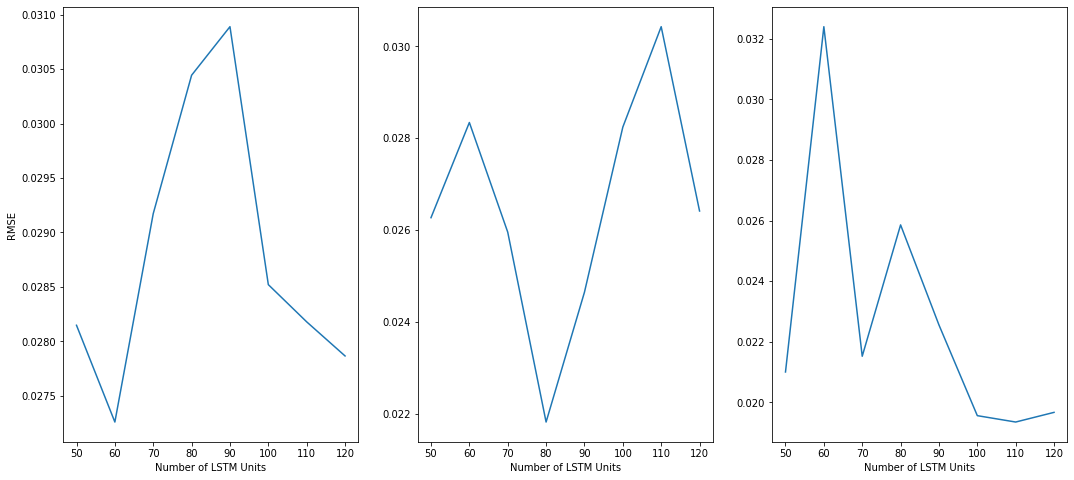

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,8))
ax1.plot(list(six_step_list.keys()), list(six_step_list.values()))
ax2.plot(list(eight_step_list.keys()), list(eight_step_list.values()))
ax3.plot(list(twelve_step_list.keys()), list(twelve_step_list.values()))
plt.setp(ax1, xlabel='Number of LSTM Units')
plt.setp(ax2, xlabel='Number of LSTM Units')
plt.setp(ax3, xlabel='Number of LSTM Units')
plt.setp(ax1, ylabel='RMSE')

In [18]:
(sx_min_rmse, sx_min_units),(et_min_rmse, et_min_units),(tw_min_rmse, tw_min_units)

((0.027258898415989347, 60),
 (0.021820544018648302, 80),
 (0.019351388122203012, 110))

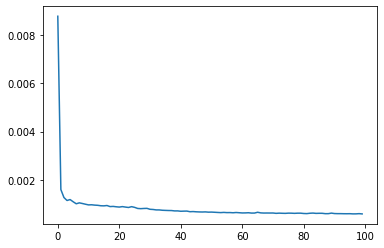

In [19]:
loss_per_epoch = selected_history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [20]:
rmse, output = evl(scaled_validation, selected_model, n_steps=min_lag)
output = scaler.inverse_transform(output)
print(rmse)

0.021591032188865097


In [21]:
otpt = pd.DataFrame(output, columns=["Original Value (MW)", "Predicted Value (MW)"])

otpt["dt"] = validation.index[min_lag+1:]
otpt = otpt.set_index("dt")
otpt.head()

,Original Value (MW),Predicted Value (MW)
dt,,
2021-09-01 13:00:00,8015.0,8182.840044
2021-09-01 14:00:00,8075.0,7996.462482
2021-09-01 15:00:00,8088.0,8119.278398
2021-09-01 16:00:00,8292.0,8023.590464
2021-09-01 17:00:00,8055.0,8181.552340


Text(0, 0.5, 'Demand (MW)')

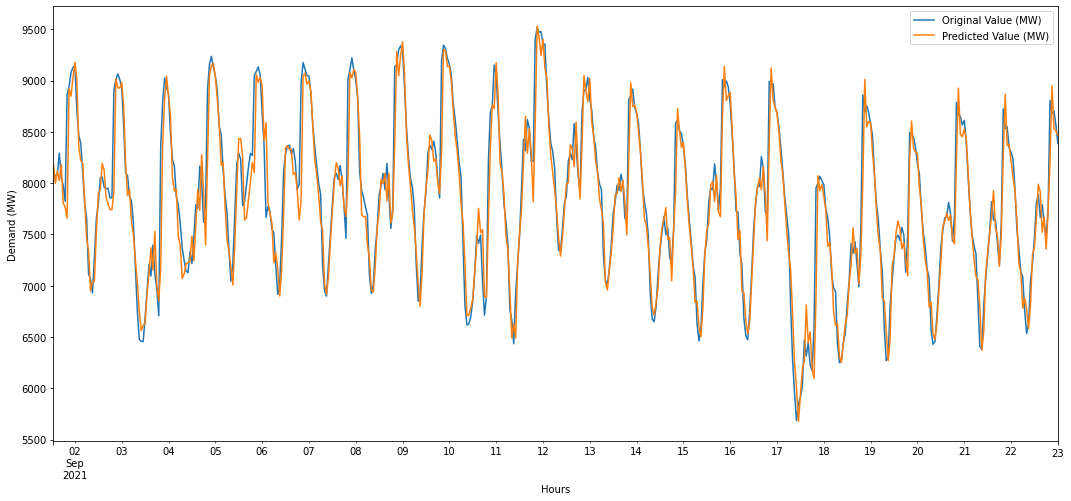

In [22]:
ax = otpt.plot(figsize=(18,8))
ax.set_xlabel("Hours")
ax.set_ylabel("Demand (MW)")

In [23]:
results = pd.DataFrame(my_items, columns=["lags", "units", "rmse"])
results.to_csv("/content/drive/MyDrive/LSTM_POWER_CLUSTERING/data/fl_data/bi_result.csv")

In [23]:
results = pd.read_csv("/content/drive/MyDrive/LSTM_POWER_CLUSTERING/data/fl_data/bi_result.csv")
sx = results.loc[ results.lags == 6,["units", "rmse"]]
sx = sx.set_index("units")
et = results.loc[ results.lags == 8,["units", "rmse"]]
et = et.set_index("units")
tw = results.loc[ results.lags == 12,["units", "rmse"]]
tw = tw.set_index("units")

[Text(0, 0.5, 'RMSE')]

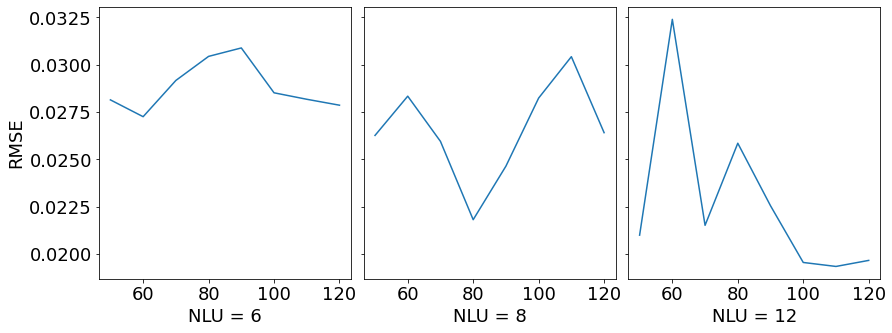

In [39]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({'font.size': 18})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,5),sharex='col', sharey='row')
plt.subplots_adjust(wspace=.05, hspace=.1)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.4f')) 
ax1.plot(sx)
ax2.plot(et)
ax3.plot(tw)
plt.setp(ax1, xlabel='NLU = 6')
plt.setp(ax2, xlabel='NLU = 8')
plt.setp(ax3, xlabel='NLU = 12')
plt.setp(ax1, ylabel='RMSE')

In [19]:
" & ".join(map(str, sx.T.iloc[0,:].values.round(4).tolist()))

'0.0281 & 0.0273 & 0.0292 & 0.0304 & 0.0309 & 0.0285 & 0.0282 & 0.0279'

In [20]:
" & ".join(map(str, et.T.iloc[0,:].values.round(4).tolist()))

'0.0263 & 0.0283 & 0.026 & 0.0218 & 0.0246 & 0.0282 & 0.0304 & 0.0264'

In [21]:
" & ".join(map(str, tw.T.iloc[0,:].values.round(4).tolist()))

'0.021 & 0.0324 & 0.0215 & 0.0259 & 0.0226 & 0.0196 & 0.0194 & 0.0197'